In [147]:
import os

import snap
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter

In [58]:
RANDOM_SEED = 42
SUCCESS = -1

In [59]:
def loadPowerGridNetwork():
    '''
    Loads the US Power Grid network as a snap.TUNGraph
    '''
    path = 'data/USpowergrid_n4941.txt'
    Graph = snap.LoadEdgeList(snap.PUNGraph, path, 0, 1, " ")
    # Delete self-edges.
    for node in Graph.Nodes():
        Graph.DelEdge(node.GetId(), node.GetId())
    assert Graph.GetNodes() == 4941
    assert Graph.GetEdges() == 6594
    return Graph

In [63]:
def GenerateConfigurationModel(nodeDegrees):
    '''
    Given a list corresponding to the degree distribution, generates
    a random, undirected network with the same degree distribution.
    
    The degree distribution assumed undirected edges.
    
    return: snap.TUNGraph
    '''
    # Note that this must hold true for any valid graph since each
    # edge increases the degree count by 2.
    assert sum(nodeDegrees) % 2 == 0
    numNodes = len(nodeDegrees)
    numEdges = sum(nodeDegrees) / 2
    
    # Generate graph.
    newGraph = snap.TUNGraph.New(numNodes, numEdges)
    for i in xrange(numNodes):
        newGraph.AddNode(i)
        
    
    # Determine edges.
    stubs = np.zeros(2*numEdges, dtype='int')
    index = 0
    for (i, ki) in enumerate(nodeDegrees):
        for _ in xrange(ki):
            stubs[index] = i
            index += 1
    # Sanity check the last value is correct.
    assert stubs[-1] == (numNodes - 1)
    
    # Keep trying until we we a valid shuffling.
    validated = False
    while not validated:
        np.random.shuffle(stubs)
        # Edges are always from lower to higher node id to avoid
        # ambiguity.
        edges = [(min(stubs[i], stubs[i + 1]),
                  max(stubs[i], stubs[i + 1]))
                 for i in xrange(0, len(stubs), 2)] 
        validated = (len(set(edges)) == len(edges) # no multi-edges
                     and 
                     all([u != v for (u,v) in edges])) # no self-edges
                     
    
    # Add edges to graph.
    for (src, dst) in edges:
        assert newGraph.AddEdge(src, dst) == SUCCESS
        
    assert newGraph.GetNodes() == numNodes
    assert newGraph.GetEdges() == numEdges
    # Validate node degree distribution is equivalent.
    assert sorted(nodeDegrees) == sorted([node.GetDeg()
                                   for node in newGraph.Nodes()])
    
    return newGraph

In [64]:
def Q1_1a():
    NUM_SAMPLE_NETWORKS = 100
    np.random.seed(RANDOM_SEED)
    powerGrid = loadPowerGridNetwork()
    dist = [node.GetDeg() for node in powerGrid.Nodes()]
    clusteringCoeffs = [snap.GetClustCf(GenerateConfigurationModel(dist))
                        for _ in xrange(NUM_SAMPLE_NETWORKS)]
    print("The mean of the average clustering coefficient for %s random "
          "network%s with the same degree distribution as the power "
          "grid network is %s." % (
              NUM_SAMPLE_NETWORKS,
              "" if NUM_SAMPLE_NETWORKS <= 1 else "s",
              np.mean(clusteringCoeffs)))

In [65]:
# Run Q1a
Q1_1a()

The mean of the average clustering coefficient for 100 random networks with the same degree distribution as the power grid network is 0.000427366228043.


In [130]:
def EdgeRewiringConfigurationModel(Graph, numIters=100):
    '''
    Given a snap.TUNGraph as input, performs rewiring on the graph
    numIters times.
    
    Returns the rewired graph (a copy of the original)
    '''
    # Implicit ordering of min -> max.
    edges = [(min(edge.GetSrcNId(), edge.GetDstNId()),
              max(edge.GetSrcNId(), edge.GetDstNId()))
             for edge in Graph.Edges()]
    indexes = np.arange(len(edges))
    edgeMap = {i : (u,v) for i, (u,v) in enumerate(edges)}
    edgeCount = Counter(edges)
    iters = 0
    while iters < numIters:
        # Find a valid rewiring.
        isValid = False
        while not isValid:
            # Select the edge indexes for efficiency.
            rand_i = np.random.choice(indexes, size=2, replace=False)
            uindex = np.random.choice([0,1])
            windex = np.random.choice([0,1])
            u,v = (edgeMap[rand_i[0]][uindex], edgeMap[rand_i[0]][1 - uindex])
            w,x = (edgeMap[rand_i[1]][windex], edgeMap[rand_i[1]][1 - windex])
            # The new proposed edges are
            # (min(u,w), max(u,w)) and
            # (min(v,x), max(v,x))
            proposed = sorted([(min(u,w), max(u,w)),
                               (min(v,x), max(v,x))])
            isValid = (
                # We rewired but kept edges the same.
                # Can happen when a node is shared.
                (len(set([u,v,w,x])) == 3 # node is shared
                 and
                 # new are same as original (implies no self-edges and no multi-edges)
                 (proposed == sorted([edgeMap[rand_i[0]], edgeMap[rand_i[1]]]))
                )
                or
                (u != w and v != x # no self edges
                 and
                 edgeCount[proposed[0]] == 0 and edgeCount[proposed[1]] == 0
                 # no multi edges
                )
            )

        # no rewiring needed here.
        if (len(set([u,v,w,x])) == 3):
            assert proposed == sorted([edgeMap[rand_i[0]], edgeMap[rand_i[1]]])
        else:
            # Delete edges by decrementing count.
            edgeCount[edgeMap[rand_i[0]]] -= 1
            assert edgeCount[edgeMap[rand_i[0]]] == 0
            edgeCount[edgeMap[rand_i[1]]] -= 1
            assert edgeCount[edgeMap[rand_i[1]]] == 0

            # Add new edges by replacing.
            edgeMap[rand_i[0]] = proposed[0]
            edgeMap[rand_i[1]] = proposed[1]
            edgeCount[edgeMap[rand_i[0]]] += 1
            assert edgeCount[edgeMap[rand_i[0]]] == 1
            edgeCount[edgeMap[rand_i[1]]] += 1
            assert edgeCount[edgeMap[rand_i[1]]] == 1
        
        # Increment
        iters += 1
    
    # We should have finished rewiring so create new graph.
    newGraph = snap.TUNGraph.New(Graph.GetNodes(), Graph.GetEdges())
    for node in Graph.Nodes():
        newGraph.AddNode(node.GetId())
    for u,v in edgeMap.values():
        assert newGraph.AddEdge(u,v) == SUCCESS
        
    assert newGraph.GetNodes() == Graph.GetNodes()
    assert newGraph.GetEdges() == Graph.GetEdges()
    # Validate node degree distribution is equivalent.
    assert (sorted([node.GetDeg() for node in Graph.Nodes()])
            == sorted([node.GetDeg() for node in newGraph.Nodes()]))
        
    # We expect the degree distributions to be the same.
    return newGraph

In [175]:
def Q1_2():
    TOTAL_ITERS = 10000
    PER_ITERS = 100
    assert TOTAL_ITERS % PER_ITERS == 0
    X = range(0, TOTAL_ITERS, PER_ITERS)
    Y = []
    graph = loadPowerGridNetwork()
    for _ in X:
        Y.append(snap.GetClustCf(graph))
        graph = EdgeRewiringConfigurationModel(graph, PER_ITERS)
    plt.close()
    plt.plot(X,Y)
    plt.title("US PowerGrid Clustering Coeff. vs # of edge rewirings.")
    plt.xlabel("Number of Edge Rewirings")
    plt.ylabel("Clustering coefficient")
    if not os.path.isdir("output"):
        os.makedirs("output")
    plt.savefig("output/1_2_plot", dpi=600)
    plt.show()

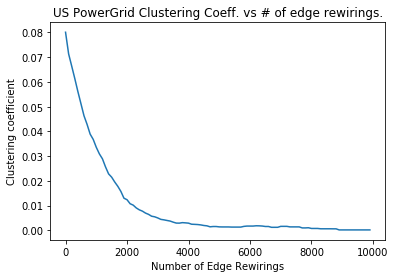

In [176]:
Q1_2()